Tematem mojego projektu będzie: **"Klasyfikacja guzów mózgu w obrazach 3D wykonanych z wykorzystaniem techniki rezonansu magnetycznego (MRI)".**

Do przeprowadzenia analizy wykorzystałam zbiór zdjęć dostępny na platformie Kaggle: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri?resource=download

Zbiór został wykorzystany między innymi w poniższych publikacjach, do których będę się odwoływać:
1. "Classification of brain tumours in MR images using deep spatiospatial models" -> https://www.nature.com/articles/s41598-022-05572-6#Sec5
2. "3D MRI brain tumor segmentation using autoencoder regularization" -> https://arxiv.org/pdf/1810.11654v3.pdf


In [ ]:
!pip install simpleitk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 15.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import torch as tc
import torchvision as tv
import matplotlib.pyplot as plt
import SimpleITK as sitk
from skimage import color
from skimage import transform
from torchvision.transforms import Resize, Grayscale, PILToTensor
from PIL import Image
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = r'/content/drive/My Drive/Data/archive' #Rozpakowane dane

In [ ]:
class OurDataset(tc.utils.data.Dataset): #Klasa, która rozpakuje mi zip z pobranymi danymi
    def __init__(self, dataset_path : str, mode : str="training"):
        self.dataset_path = dataset_path
        self.mode = mode #"Testing" lub "Training"

        if self.mode == "training":
            self.data_path = os.path.join(self.dataset_path, "Training")
        elif self.mode == "testing":
            self.data_path = os.path.join(self.dataset_path, "Testing")
        else:
            raise ValueError("Unsupported mode.")

        self.classes = os.listdir(self.data_path) #Zakładamy, że foldery odpowiadają klasom
        print(f"Available classes: {self.classes}")
        self.classes_dict = {self.classes[i]: i for i in range(len(self.classes))}
        print(f"Classes dict: {self.classes_dict}") #Przekształcenie nazw klas na liczby  

#Źródło implementacji: https://www.youtube.com/watch?v=oWq6aVv5mC8 oraz https://pytorch.org/tutorials/beginner/basics/data_tutorial.html 
#Są to klasy do wczytywania danych
#Źródło: https://stackoverflow.com/questions/33533148/how-do-i-type-hint-a-method-with-the-type-of-the-enclosing-class
#self.cases odnosi się do wszystkich przypadków w zbiorze testowym 

        self.cases = []
        for current_class in self.classes:
            for current_case in os.listdir(os.path.join(self.data_path, current_class)):
                case_path = os.path.join(self.data_path, current_class, current_case)
                self.cases.append((case_path, self.classes_dict[current_class]))

#Sprawdzenie jak duży jest zestaw danych
    def __len__(self):
        if len(self.cases) > 4000: #Maksymalna wielkość zbioru to 4k
          raise DatasetTooBigError(self.__len__) #Sprawdzenie czy nie ma erroru; źródło: https://github.com/cleanlab/cleanlab
        else:
          return len(self.cases)

    def __getitem__(self, idx):
        current_case = self.cases[idx]
        current_path = current_case[0]
        current_class = current_case[1]
        current_image = Image.open(current_path) #Wczytanie obrazu ze ścieżki
#Z racji tego, że są to obrazki, należy je sprowadzić do jednakowej rozdzielczości
        current_image = Resize((224, 224))(current_image) #przekształcenie i pogrupowanie do rozmiaru 224x224
        current_image = PILToTensor()(Grayscale()(current_image)).to(tc.float32) #zmiana skali na szarość i do typu float
        current_image = current_image / (current_image.max() - current_image.min()) #normalizacja danych do zakresu [0-1]
    
        return current_image, current_class

#Utworzenie zbioru treningowego
training_dataset = OurDataset(path, "training") 
#Utworzenie zbioru testowego
testing_dataset = OurDataset(path, "testing") 
#Rozmiar batcha, czyli nasz (w tym przypadku) szacowany hiperparametr do treningu; ile danych ma zostać wczytanych i przetworzonych
batch_size = 16 
#Wartość "True" odnosi się do danych (obrazków) wczytywanych losowo w kolejnych epokach
shuffle = True 
#"Uruchomienie" zbiorów
training_dataloader = tc.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=shuffle)
testing_dataloader = tc.utils.data.DataLoader(testing_dataset, batch_size=1, shuffle=False) 

Available classes: ['meningioma_tumor', 'no_tumor', 'glioma_tumor', 'pituitary_tumor']
Classes dict: {'meningioma_tumor': 0, 'no_tumor': 1, 'glioma_tumor': 2, 'pituitary_tumor': 3}
Available classes: ['glioma_tumor', 'meningioma_tumor', 'pituitary_tumor', 'no_tumor']
Classes dict: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'pituitary_tumor': 2, 'no_tumor': 3}


Powyżej można się także odwołać bezpośrednio do źródeł, na przykład w postaci importowania ścieżek bezpośrednio z linków: 

import os
train_loc = '/kaggle/input/brain-tumor-classification-mri/Training'
test_loc = '/kaggle/input/brain-tumor-classification-mri/Testing'

Uwaga: testowałam sposób i nie jest on kompletny (sprawdzenie fotografii z bezpośredniego źródła: https://github.com/sartajbhuvaji/brain-tumor-classification-dataset -> gotowe grupowania do zbiorów treningowego i testowego

BARDZIEJ SZCZEGÓŁOWY OPIS I LINKI DO ŹRÓDEŁ KODU W OPISIE PROJEKTU.

In [ ]:
#Sprawdzam czy powyższa implementacja działa
for image, classes in training_dataloader:
  print(image)
  print(classes)

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0044, 0.0044, 0.0044,  ..., 0.0089, 0.0089, 0.0089],
          [0.0089, 0.0089, 0.0089,  ..., 0.0133, 0.0133, 0.0133],
          ...,
          [0.0089, 0.0089, 0.0089,  ..., 0.0089, 0.0089, 0.0089],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..

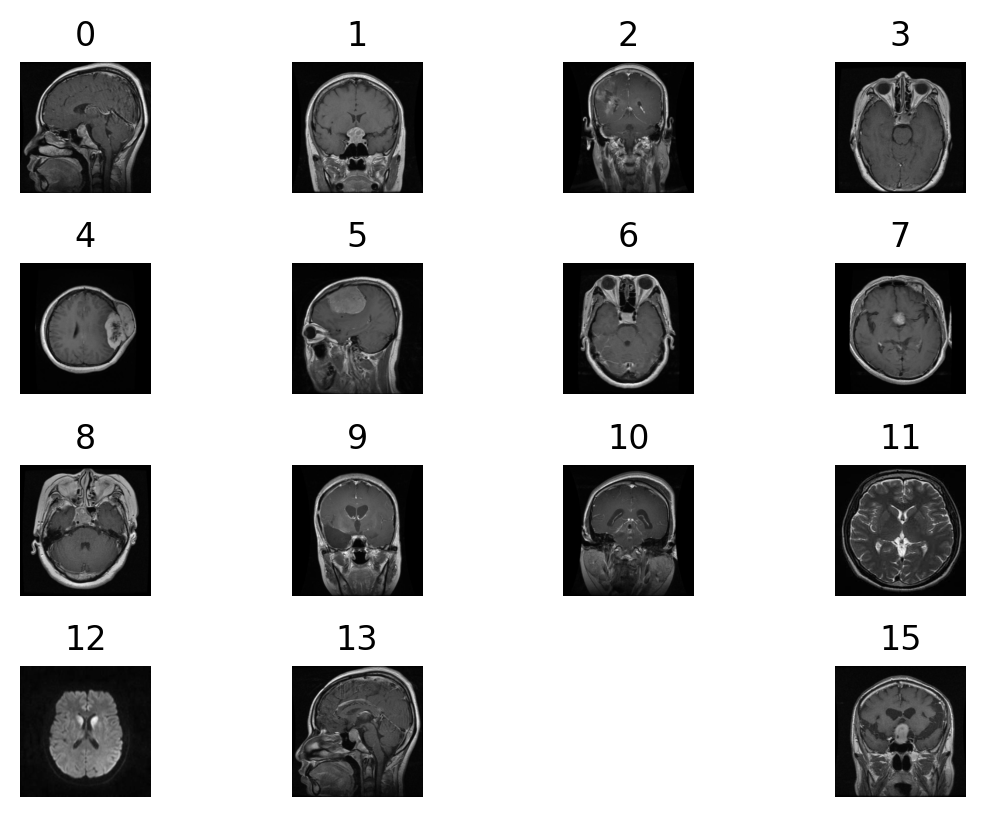

In [ ]:
#Pokazywanie wczytywanych przypadków
for images, classes in training_dataloader:
    plt.figure(dpi=200)

    for i in range(images.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(i)
        plt.axis('off')
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.show()

tensor([2, 2, 2, 3, 2, 2, 2, 1, 3, 0, 2, 0, 3, 3, 3, 2])


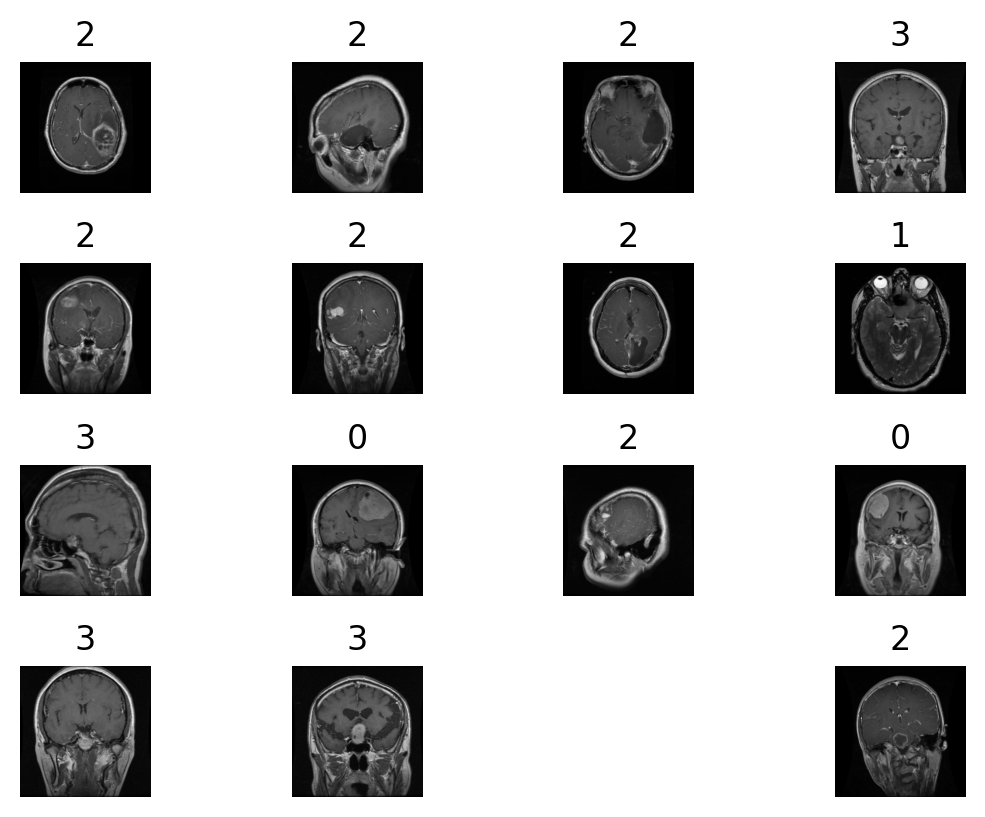

In [ ]:
#Porównanie obrazów z klasami otrzymanymi w pierwszej komórce
for images, classes in training_dataloader:
    print(classes)
    plt.figure(dpi=200)

    for i in range(images.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(classes[i].item())
        plt.axis('off')
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.show()

In [ ]:
#Implementacja sieci konwolucyjnej
class CNNNetwork(tc.nn.Module):
    def __init__(self):
        super(SimpleNetwork, self).__init__()

        self.layer_1 = tc.nn.Sequential(
            tc.nn.Conv2d(1, 32, 3, stride=1, padding=1),
            tc.nn.BatchNorm2d(32), 
            tc.nn.ReLU()
        ) 
        self.layer_2 = tc.nn.Sequential(
            tc.nn.Conv2d(32, 32, 3, stride=2, padding=1),
            tc.nn.BatchNorm2d(32),
            tc.nn.ReLU()
        ) 
        
        self.layer_3 = tc.nn.Sequential(
            tc.nn.Conv2d(32, 64, 3, stride=1, padding=1),
            tc.nn.BatchNorm2d(64),
            tc.nn.ReLU()
        ) 
        
        self.layer_4 = tc.nn.Sequential(
            tc.nn.Conv2d(64, 64, 3, stride=2, padding=1),
            tc.nn.BatchNorm2d(64),
            tc.nn.ReLU()
        ) 
        
        self.layer_5 = tc.nn.Sequential(
            tc.nn.Conv2d(64, 128, 3, stride=1, padding=1),
            tc.nn.BatchNorm2d(128),
            tc.nn.ReLU()
        )
        
        self.layer_6 = tc.nn.Sequential(
            tc.nn.Conv2d(128, 128, 3, stride=2, padding=1),
            tc.nn.BatchNorm2d(128),
            tc.nn.ReLU()
        )
        
        self.layer_7 = tc.nn.Sequential(
            tc.nn.Conv2d(128, 128, 3, stride=1, padding=1),
            tc.nn.BatchNorm2d(128),
            tc.nn.ReLU()
        )
        
        self.avg_pool = tc.nn.AvgPool2d(2, 2)
        self.last_layer = tc.nn.Linear(25088,4)

    def forward(self, x):
        x = self.layer_1(x) 
        x = self.layer_2(x) 
        x = self.layer_3(x)  
        x = self.layer_4(x) 
        x = self.layer_5(x) 
        x = self.layer_6(x) 
        x = self.layer_7(x) 
        x = self.avg_pool(x) 
        x = x.view(x.size(0), -1) 
        x = self.last_layer(x) 
        return x

In [ ]:
model = CNNNetwork()
for images, classes in training_dataloader:
    output = model(images) 
    print(f"Output: {tc.nn.Sigmoid()(output)}") 
    break

Output: tensor([[0.4935, 0.4576, 0.5460, 0.4870],
        [0.4329, 0.4952, 0.5368, 0.5960],
        [0.4543, 0.4555, 0.5897, 0.5338],
        [0.4532, 0.5088, 0.5755, 0.5378],
        [0.5078, 0.5160, 0.5082, 0.5641],
        [0.5388, 0.4400, 0.4746, 0.5681],
        [0.5733, 0.5181, 0.5472, 0.5673],
        [0.5080, 0.5272, 0.5458, 0.5357],
        [0.5798, 0.5347, 0.5383, 0.5337],
        [0.4544, 0.4971, 0.5787, 0.6107],
        [0.5260, 0.4841, 0.5116, 0.4822],
        [0.4912, 0.4299, 0.5350, 0.5781],
        [0.4939, 0.4778, 0.5893, 0.5884],
        [0.4979, 0.4218, 0.4990, 0.5637],
        [0.5413, 0.4967, 0.5040, 0.5143],
        [0.4981, 0.5557, 0.5764, 0.6466],
        [0.5370, 0.4870, 0.5695, 0.6060],
        [0.5074, 0.4887, 0.5277, 0.4786],
        [0.5266, 0.4691, 0.5426, 0.6003],
        [0.6136, 0.4966, 0.4465, 0.5743],
        [0.5462, 0.4702, 0.5678, 0.6468],
        [0.5992, 0.5182, 0.5227, 0.6266],
        [0.5377, 0.4242, 0.4547, 0.5320],
        [0.5031, 0.4469, 0

In [ ]:
#Dobieram parametry do treningu
learning_rate = 0.0003 
batch_size = 32 
num_epochs = 5 
objective_function = tc.nn.CrossEntropyLoss() 
model = SimpleNetwork()
parameters = model.parameters()
optimizer = tc.optim.Adam(parameters, lr=learning_rate) 
device = "cpu" #Zmieniłam na cpu 

training_dataset = OurDataset(path_to_dataset, "training")
shuffle = True 
training_dataloader = tc.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=shuffle)

Available classes: ['meningioma_tumor', 'no_tumor', 'glioma_tumor', 'pituitary_tumor']
Classes dict: {'meningioma_tumor': 0, 'no_tumor': 1, 'glioma_tumor': 2, 'pituitary_tumor': 3}


Dataset size: 2870
Current epoch: 0
Current epoch loss: 1.0695146158597195
Current epoch: 1
Current epoch loss: 0.9481723635869574
Current epoch: 2
Current epoch loss: 0.915493529058915
Current epoch: 3
Current epoch loss: 0.882051127463683
Current epoch: 4
Current epoch loss: 0.8633689441332003


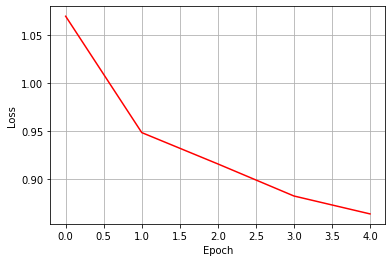

In [ ]:
losses = []
model = model.to(device)
model.train()
print(f"Dataset size: {len(training_dataloader.dataset)}")
for epoch in range(num_epochs):
    print(f"Current epoch: {epoch}")
    epoch_loss = 0.0
    for images, classes in training_dataloader:
        # print(classes)
        images, classes = images.to(device), classes.to(device) 
        output = model(images) 
        loss = objective_function(tc.nn.Sigmoid()(output), classes) 
        loss.backward()  
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss += loss.item() * images.size(0)
    epoch_loss = epoch_loss / len(training_dataloader.dataset)
    losses.append(epoch_loss)
    print(f"Current epoch loss: {epoch_loss}")

#Pętla treningowa
plt.figure()
plt.plot(losses, "r-")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [ ]:
model.state_dict()

OrderedDict([('layer_1.0.weight', tensor([[[[ 0.2044, -0.3086,  0.3245],
                        [-0.1217, -0.3303,  0.0585],
                        [ 0.1397,  0.1553, -0.1188]]],
              
              
                      [[[ 0.0596,  0.2637, -0.0773],
                        [ 0.0445,  0.1515,  0.0401],
                        [ 0.1729,  0.0155,  0.0368]]],
              
              
                      [[[-0.3046,  0.1730, -0.1377],
                        [ 0.2023, -0.1990, -0.2448],
                        [-0.2608,  0.2046,  0.1690]]],
              
              
                      [[[ 0.2695,  0.2374, -0.1671],
                        [-0.0192,  0.0988, -0.0360],
                        [ 0.0755, -0.2704,  0.0265]]],
              
              
                      [[[ 0.2204, -0.2230,  0.3196],
                        [ 0.2101, -0.2639, -0.0975],
                        [ 0.2404, -0.3237, -0.2889]]],
              
              
                      [[[

In [ ]:
import sklearn.metrics as metrics
correct = 0
predictions = []
targets = []
model.eval()
with tc.set_grad_enabled(False):
    print(f"Dataset size: {len(training_dataloader.dataset)}")
    for images, classes in training_dataloader:
        images, classes = images.to(device), classes.to(device)
        output = model(images)
        prediction = tc.argmax(tc.nn.Sigmoid()(output), dim=1)
        predictions.append(prediction) #Predykcje
        correct += (prediction == classes).sum().item() #Wartości prawdziwe
        targets.append(classes)


#Macierz pomyłek
targets = np.concatenate([target.cpu().detach().numpy() for target in targets]) 
predictions = np.concatenate([prediction.cpu().detach().numpy() for prediction in predictions]) 
confusion_matrix = metrics.confusion_matrix(targets, predictions)

Dataset size: 2870


In [ ]:
confusion_matrix

array([[696,  76,   4,  46],
       [ 20, 366,   4,   5],
       [143,   0, 677,   6],
       [ 17,   2,   3, 805]])

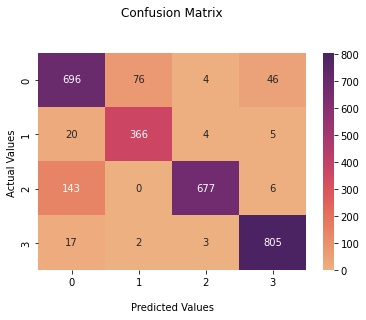

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt
ax = sns.heatmap(confusion_matrix, annot=True, cmap="flare", fmt='g') 
ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['0','1', '2', '3'])
ax.yaxis.set_ticklabels(['0','1','2','3'])
plt.show()

In [ ]:
predictions = []
targets = []
correct = 0
model.eval()
with tc.set_grad_enabled(False):
    print(f"Dataset size: {len(testing_dataloader.dataset)}")
    for images, classes in testing_dataloader:
        images, classes = images.to(device), classes.to(device)
        output = model(images)
        prediction = tc.argmax(tc.nn.Sigmoid()(output), dim=1)
        predictions.append(prediction) #Predykcje
        correct += (prediction == classes).sum().item() #Wartości prawdziwe
        targets.append(classes)

Dataset size: 394


In [ ]:
targets = np.concatenate([target.cpu().detach().numpy() for target in targets]) 
predictions = np.concatenate([prediction.cpu().detach().numpy() for prediction in predictions]) 
confusion_matrix = metrics.confusion_matrix(targets, predictions) 

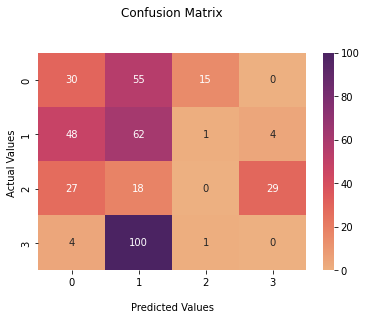

In [ ]:
ax = sns.heatmap(confusion_matrix, annot=True, cmap="flare", fmt='g') 
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['0','1', '2', '3'])
ax.yaxis.set_ticklabels(['0','1','2','3'])
plt.show()

tensor([0])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([0])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([0])
tensor([1])
tensor([0])
tensor([0])
tensor([0])
tensor([1])
tensor([1])
tensor([1])
tensor([0])
tensor([1])


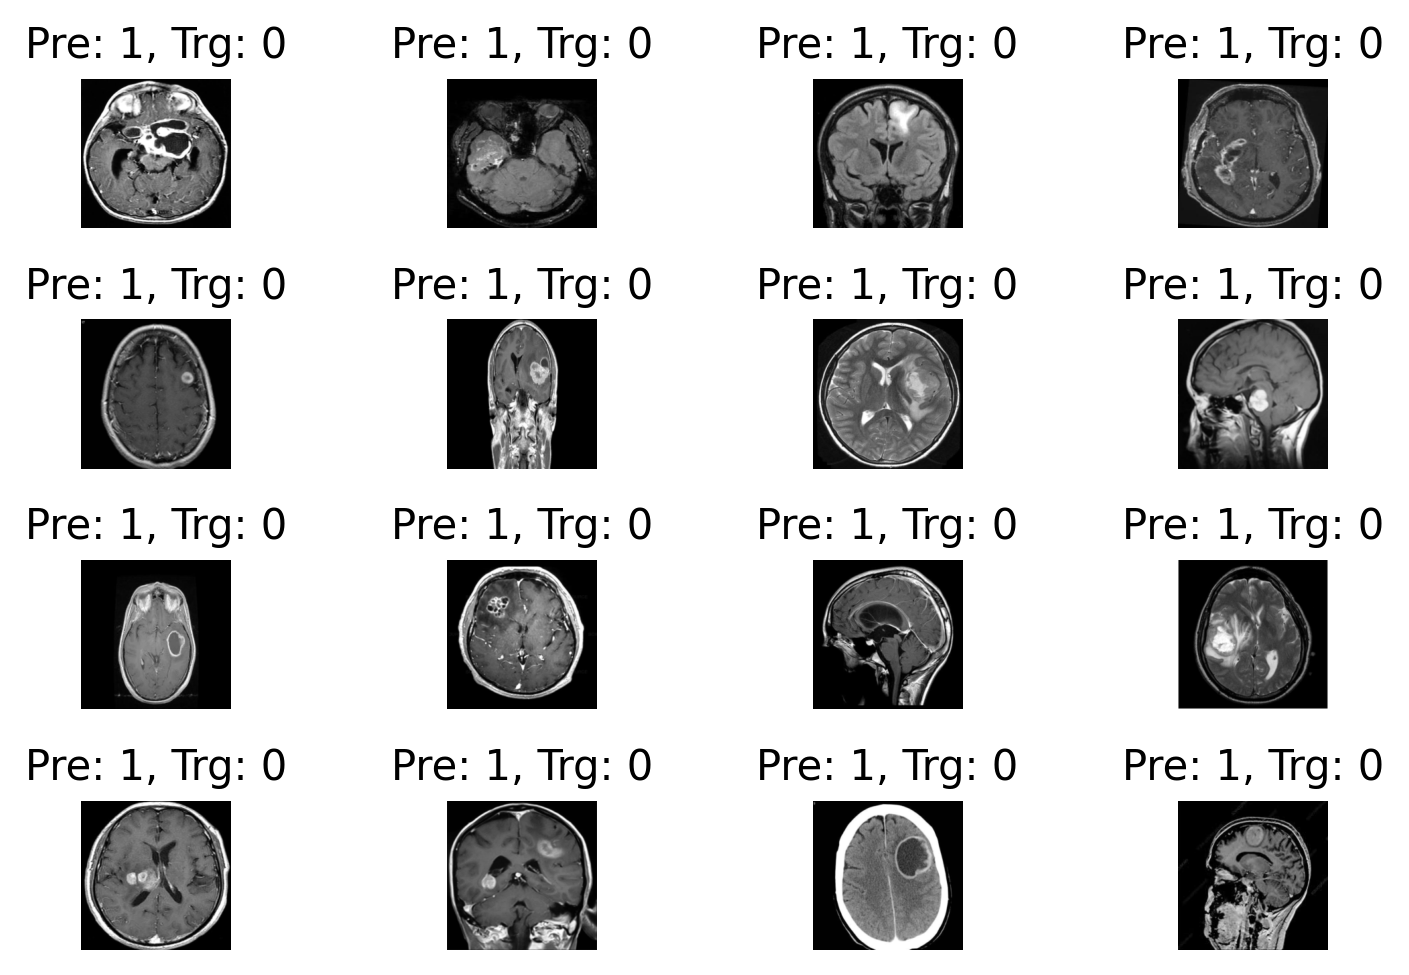

In [ ]:
incorrect_tuples = []
predictions = []
max_size = 16
for images, classes in testing_dataloader:
    images, classes = images.to(device), classes.to(device)
    output = model(images) 
    prediction = tc.argmax(tc.nn.Sigmoid()(output), dim=1) #Predykcja klasy
    predictions.append(prediction) 
    
    print(prediction)
    for index, (predicted_class, actual_calss) in enumerate(zip(prediction.unbind(0), classes.unbind(0))):
        if predicted_class != actual_calss:
          incorrect_tuples.append((images[index].cpu().detach().numpy(), predicted_class, actual_calss))
    if len(incorrect_tuples) == 16:
      break     
rows = 4
cols = 4
plt.figure(dpi=250)
for i in range(len(incorrect_tuples)):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(incorrect_tuples[i][0][0], cmap='gray')
    to_print = f"Pre: {incorrect_tuples[i][1]}, Trg: {incorrect_tuples[i][2]}"
    plt.title(to_print)
    plt.axis('off')
plt.tight_layout()
plt.show()

**Próba drugiego sposobu porównania danych**

In [ ]:
import pandas as pd
import numpy as np
np.random.seed(0)
seed = 0
import warnings
import cv2
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [ ]:
from sklearn.decomposition import KernelPCA
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

W tym momencie już pomijam dopasowanie danych, bo biorę gotowy zestaw, który jest powyżej. Zmieniam oznaczenie. Kodem posiłkuję się ze strony:
https://www.kaggle.com/code/priyanshzalavadiya/cnn-with-100-training-accuracy

In [ ]:
y_train = pd.concat([y_train,y_train])
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
y_train

array([[1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       ...,
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1]], dtype=uint8)

In [ ]:
input_layer = keras.Input(shape=[X_train.shape[1],X_train.shape[2], X_train.shape[3]])

h1 = layers.Conv2D(64, kernel_size=(5, 5),padding = 'Same', activation="relu")(input_layer)
h1 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2))(h1)
h1 = layers.Dropout(0.25)(h1)

h2 = layers.Conv2D(128, kernel_size=(3, 3),padding = 'Same', activation="relu")(h1)
h2 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2))(h2)
h2 = layers.Dropout(0.25)(h2)

h3 = layers.Conv2D(128, kernel_size=(2, 2),padding = 'Same', activation="relu")(h2)
h3 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2))(h3)
h3 = layers.Dropout(0.3)(h3)

h4 = layers.Conv2D(256, kernel_size=(2, 2),padding = 'Same', activation="relu")(h3)
h4 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2))(h4)
h4 = layers.Dropout(0.3)(h4)

h4 = layers.Flatten()(h4)

h5 = layers.Dense(1024, activation="relu")(h4)
h5 = layers.Dropout(0.5)(h5)

h6 = layers.Dense(4, activation="softmax")(h5)

optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

model = keras.Model(inputs=input_layer, outputs=h6)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
epochs = 10  
batch_size = 32

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 255, 255, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 255, 255, 64)      4864      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 127, 127, 64)     0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 127, 127, 64)      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 127, 127, 128)     73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 63, 63, 128)      0         
 2D)                                                       

In [ ]:
model_result = model.fit(X_train, 
                         y_train, 
                         batch_size=batch_size,
                         epochs=epochs, 
                         validation_split=0.2,
                         callbacks=[reduce_lr])

Epoch 1/10
115/115 [==============================] - 830s 7s/step - loss: 58.1386 - accuracy: 0.4015 - val_loss: 1.2599 - val_accuracy: 0.4683 - lr: 0.0010
Epoch 2/10
115/115 [==============================] - 830s 7s/step - loss: 1.1033 - accuracy: 0.5194 - val_loss: 1.0767 - val_accuracy: 0.5208 - lr: 0.0010
Epoch 3/10
115/115 [==============================] - 824s 7s/step - loss: 0.9320 - accuracy: 0.6045 - val_loss: 1.0863 - val_accuracy: 0.5252 - lr: 0.0010
Epoch 4/10
115/115 [==============================] - 830s 7s/step - loss: 0.8282 - accuracy: 0.6604 - val_loss: 0.9257 - val_accuracy: 0.5832 - lr: 0.0010
Epoch 5/10
115/115 [==============================] - 830s 7s/step - loss: 0.7057 - accuracy: 0.7214 - val_loss: 1.0425 - val_accuracy: 0.5832 - lr: 0.0010
Epoch 6/10
115/115 [==============================] - 843s 7s/step - loss: 0.6429 - accuracy: 0.7427 - val_loss: 0.7510 - val_accuracy: 0.6816 - lr: 0.0010
Epoch 7/10
115/115 [==============================] - 840s 7s/s

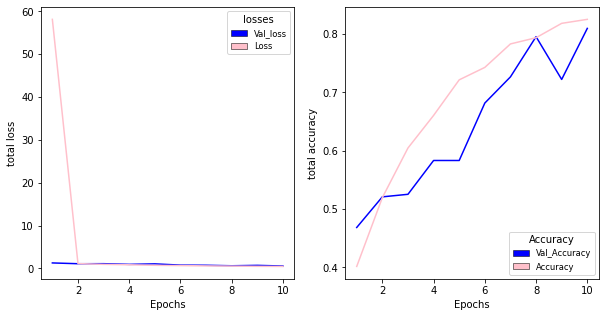

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))

metrics = model_result.history
epochs = np.linspace(1, 10, 10)
ax1.set(xlabel='Epochs', ylabel='total loss')
ax1.plot(epochs,metrics['val_loss'], color='blue')
ax1.plot(epochs,metrics['loss'], color='pink')
one = mpatches.Patch(facecolor='blue', label='Val_loss', linewidth = 0.5, edgecolor = 'black')
two = mpatches.Patch(facecolor='pink', label = 'Loss', linewidth = 0.5, edgecolor = 'black')
ax1.legend(handles=[one, two], title="losses",
                    loc=1, fontsize='small', fancybox=True)

ax2.plot(epochs,metrics['val_accuracy'], color='blue')
ax2.plot(epochs,metrics['accuracy'], color='pink')
ax2.set(xlabel='Epochs', ylabel='total accuracy')
one = mpatches.Patch(facecolor='blue', label='Val_Accuracy', linewidth = 0.5, edgecolor = 'black')
two = mpatches.Patch(facecolor='pink', label = 'Accuracy', linewidth = 0.5, edgecolor = 'black')
ax2.legend(handles=[one, two], title="Accuracy",
                    loc=4, fontsize='small', fancybox=True)

In [ ]:
y_pred = model.predict(X_test)
arr = []
for item in y_pred:
    result = np.where(item == np.amax(item))
    arr.append(result[0][0])
y_pred_new = np.array(arr)
y_pred_new = pd.get_dummies(y_pred_new)
y_pred_new = y_pred_new.idxmax(axis=1)
y_test_new = pd.DataFrame(y_test)
y_test_new = y_test_new.idxmax(axis=1)
y_test_new

31/31 [==============================] - 54s 2s/step


0      3
1      0
2      3
3      2
4      1
      ..
975    1
976    0
977    2
978    2
979    3
Length: 980, dtype: int64

In [ ]:
print(classification_report(np.array(y_test_new), np.array(y_pred_new), target_names=["No Tumor",
                                                                                      "Glioma Tumor",
                                                                                      "Meningioma tumor",
                                                                                      "Pituitary tumor"]))

                  precision    recall  f1-score   support

        No Tumor       0.80      0.83      0.81       155
    Glioma Tumor       0.83      0.71      0.77       253
Meningioma tumor       0.77      0.79      0.78       303
 Pituitary tumor       0.86      0.94      0.90       269

        accuracy                           0.82       980
       macro avg       0.82      0.82      0.81       980
    weighted avg       0.82      0.82      0.81       980



Podjęłam także próbę implementacji sieci U-Net, żeby przy okazji klasyfikacji sprawdzić czy badane struktury są prawdziwe (guz jest/ guza nie ma) -> tak podaje druga publikacja, ale niestety sieć wytrenowała się w moim przypadku fatalnie. Bierze nie to co potrzeba pod uwagę. Dlatego wrzucam, że coś takiego próbowałam, ale nie ma efektu. 

In [ ]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3)
    
    def forward(self, x):
        return self.conv2(self.relu(self.conv1(x)))


class Encoder(nn.Module):
    def __init__(self, chs=(3,64,128,256,700, 512,1024)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2)
    
    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs


class Decoder(nn.Module):
    def __init__(self, chs=(1024, 700, 512, 256, 128, 64)):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
        
    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x        = tc.cat([x, enc_ftrs], dim=3)
            x        = self.dec_blocks[i](x)
        return x
    
    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = tv.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs


class Registration_Network(nn.Module):
    def __init__(self, enc_chs=(3,64,128,256,700,1024), dec_chs=(1024, 512, 256, 128, 64), num_class=1, retain_dim=True, out_sz=(700, 512)):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim  = retain_dim
        self.out_sz = out_sz
    def forward(self, x, y):
        x = tc.cat((x, y), dim=0)
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = self.head(out)
        if self.retain_dim:
            out = nn.functional.interpolate(out, self.out_sz)
        return out

    

def load_network(weights_path=None):
    model = Registration_Network()
    if weights_path is not None:
        model.load_state_dict(tc.load(weights_path))
        model.eval()
    return model

def test_forward_pass():
    device = "cpu"
    model = load_network().to(device)
    y_size, x_size = 700, 512
    no_channels = 1
    batch_size = 1

    example_input_1 = tc.rand((batch_size, no_channels, y_size, x_size)).to(device)
    example_input_2 = tc.rand((batch_size, no_channels, y_size, x_size)).to(device)
    result = model(example_input_1, example_input_2)
    print("Result size: ", result.size())

test_forward_pass()